# Public and Private CNNs

**Import Libraries**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import numpy as np
import emnist as emnist
import string
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from neural import PrivateModel, PublicModel
from helper import Helper

**Load EMNIST Data**

In [4]:
images = np.load('./test_gen_data/images_ft.npy').astype(np.float32)
labels = np.load('./test_gen_data/labels_ft.npy').astype(np.uint8)
second_labels = Helper.AddLabel(labels).astype(np.uint8)

In [5]:
print(images.shape)

(8236, 16, 16)


In [6]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, shuffle=True)
public_images_train, public_images_test, public_labels_train, public_labels_test = train_test_split(images, second_labels, shuffle=True)

images_train, images_val, labels_train, labels_val = train_test_split(images_train, labels_train, test_size=0.10, shuffle=True)
public_images_train, public_images_val, public_labels_train, public_labels_val = train_test_split(public_images_train, public_labels_train, test_size=0.10, shuffle=True)

**Dataset and Dataloader**

In [7]:
class EmnistCustomDataset(Dataset):
    """EMNIST numbers and uppercase letters dataset."""

    def __init__(self, labels, images, transform=None):
        """
        Args:
        labels (array): array of the labels
        images (array): image array
        transform (callable, optional): optional transform to be applied on a sample.
        """
        self.labels = labels
        # self.second_labels = second_labels
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx,:,:]
        label = self.labels[idx]
        # second_label = self.second_labels[idx]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [8]:
bs = 16

labels_unique, counts = np.unique(public_labels_train, return_counts=True)
print(labels_unique, counts)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in public_labels_train]
print(np.shape(example_weights))
train_sampler = WeightedRandomSampler(example_weights, len(public_labels_train))

labels_unique, counts = np.unique(public_labels_val, return_counts=True)
print(labels_unique, counts)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in public_labels_val]
print(np.shape(example_weights))
val_sampler = WeightedRandomSampler(example_weights, len(public_labels_val))

labels_unique, counts = np.unique(public_labels_test, return_counts=True)
print(labels_unique, counts)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in public_labels_test]
print(np.shape(example_weights))
test_sampler = WeightedRandomSampler(example_weights, len(public_labels_test))

[0 1] [1492 4067]
(5559,)
[0 1] [182 436]
(618,)
[0 1] [ 593 1466]
(2059,)


In [9]:
emnist_custom_dataset = EmnistCustomDataset(labels_train, images_train, transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]))
trainloader = DataLoader(emnist_custom_dataset, batch_size=bs, shuffle=True)

emnist_custom_dataset = EmnistCustomDataset(labels_val, images_val, transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]))
valloader = DataLoader(emnist_custom_dataset, batch_size=bs, shuffle=True)

emnist_custom_dataset_test = EmnistCustomDataset(labels_test, images_test, transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]))
testloader = DataLoader(emnist_custom_dataset_test, batch_size=bs, shuffle=True) 

In [10]:
emnist_custom_dataset_2 = EmnistCustomDataset(public_labels_train, public_images_train, transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]))
public_trainloader = DataLoader(emnist_custom_dataset_2, sampler=train_sampler, batch_size=bs, shuffle=False) 

emnist_custom_dataset_2 = EmnistCustomDataset(public_labels_val, public_images_val, transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]))
public_valloader = DataLoader(emnist_custom_dataset_2, sampler=val_sampler, batch_size=bs, shuffle=False) 

emnist_custom_dataset_test_2 = EmnistCustomDataset(public_labels_test, public_images_test, transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]))
public_testloader = DataLoader(emnist_custom_dataset_test_2, sampler=test_sampler, batch_size=bs, shuffle=False) 

**Device**

In [11]:
# select GPU / CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda:0


## Private CNN

In [12]:
private_model = PrivateModel().to(device)
print(private_model)

PrivateModel(
  (conv1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(20, 22, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(22, 10, kernel_size=(3, 3), stride=(2, 2), padding=(5, 5))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (out): Linear(in_features=2890, out_features=36, bias=True)
)


**Training**

In [ ]:
private_model.load_state_dict(torch.load('./resources/private_model_21.pt'))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(private_model.parameters(), lr=0.00001)

private_model.train()

time0 = time()
epochs = 300
last_loss = 100
patience = 3
trigger_times = 0
loss_margin = 0.01

current_loss = 0.7010402273984603

losses = np.zeros((epochs,2))

for epoch in range(epochs):  # loop over the dataset multiple times

    with torch.enable_grad():
        private_model.train()
        running_loss = 0.0
        for data in trainloader:
            # get data
            images = data['image']
            labels = data['label']

            # send to device
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = private_model(images)
            loss = loss_fn(outputs[0], labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))
            losses[epoch,0] = running_loss/len(trainloader)
    
    if epoch % 1 == 0:
        with torch.no_grad():
            private_model.eval()
            loss_total = 0
            for data in valloader:
                outputs = private_model(data['image'].to(device))
                loss = loss_fn(outputs[0],data['label'].to(device))
                loss_total += loss.item()
        
        current_loss = loss_total / len(valloader)
        print('current val loss: ', current_loss)
        losses[epoch,1] = current_loss
        print(current_loss - (running_loss/len(trainloader)))

        if (current_loss - (running_loss/len(trainloader))) > loss_margin:
            trigger_times += 1
            if trigger_times > patience:
                print('Early stopping!')
                path = f"./test_gen_data/private_ft_model_{epoch}.pt"
                torch.save(private_model.state_dict(), path)
                if trigger_times > patience and trigger_times < (patience + 2):
                    path_to_use = path
                    break
        last_loss = current_loss


plt.ion()
fig, ax = plt.subplots()
x = range(epochs)
plot0, = ax.plot(x, losses[:,0])
plot1, = ax.plot(x, losses[:,1])
plt.show()
print("\nTraining Finished. \nTraining Time (in minutes) =",(time()-time0)/60)

In [14]:
# path = f"./private_models/private_ft_model_{epoch}.pt"
# torch.save(private_model.state_dict(), path)
# path_to_use = path

**Testing**

In [15]:
private_model.load_state_dict(torch.load(path_to_use))

y_pred = []
y_true = []

with torch.no_grad():
    private_model.eval()
    correct, total = 0, 0
    for data in valloader:
        outputs = private_model(data['image'].to(device))
        _, prediction = torch.max(outputs[0], 1)
        torch.set_printoptions(threshold=10_000)
        y_pred.extend(prediction.cpu()) # Save Prediction
        y_true.extend(data['label']) # Save Truth
        for i in range(len(data['label'])):
            if(prediction[i]==data['label'][i]):
                correct += 1
            total += 1

print("Number Of Images Tested =", total)
print("\nModel Accuracy =", (correct/total))

Number Of Images Tested = 618

Model Accuracy = 0.02750809061488673


<AxesSubplot:>

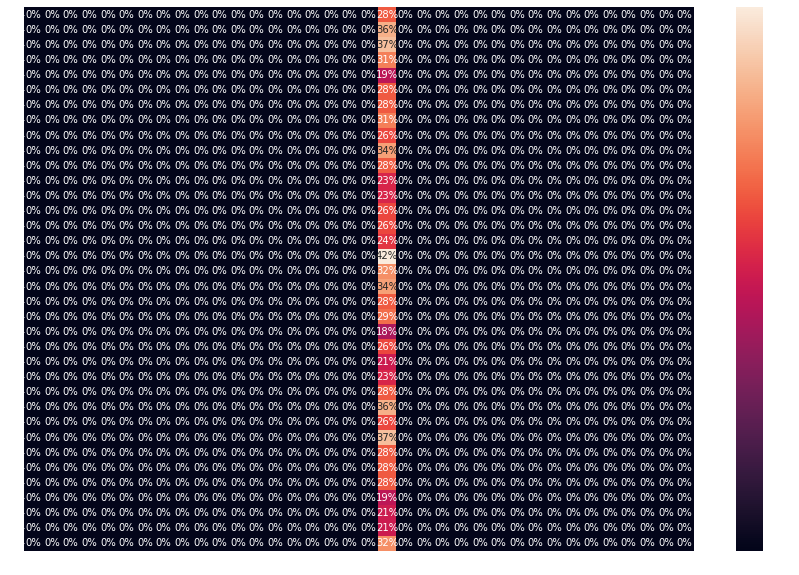

In [16]:
# labels for classes
classes = string.digits + string.ascii_uppercase

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt='.0%')
# plt.savefig('output.png')

## Public CNN

In [17]:
public_model = PublicModel().to(device)
print(public_model)

PublicModel(
  (conv1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(20, 22, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(22, 10, kernel_size=(3, 3), stride=(2, 2), padding=(5, 5))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(10, 5, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv7): Sequential(
    (0): Conv2d(5, 5, kernel_size=(2, 2), stride=(1, 1), padding=(5, 5))
    (1): ReLU()
    (2): MaxPool2

**Training**

Epoch 0 - Training loss: 1.8973924664930366
current val loss:  1.7299368060552156
-0.167455660437821
Epoch 1 - Training loss: 1.496839816971072
current val loss:  1.4568748871485393
-0.039964929822532635
Epoch 2 - Training loss: 1.3121836822608421
current val loss:  1.1786901652812958
-0.13349351697954637
Epoch 3 - Training loss: 1.1573075478275616
current val loss:  1.1808093373592083
0.023501789531646722
Epoch 4 - Training loss: 1.0314580673116378
current val loss:  1.017873038084079
-0.013585029227558776
Epoch 5 - Training loss: 0.9699725267188303
current val loss:  0.9388140455270425
-0.031158481191787768
Epoch 6 - Training loss: 0.9285925324449594
current val loss:  0.8563287533246554
-0.07226377912030402
Epoch 7 - Training loss: 0.879493457661278
current val loss:  0.8745657908610809
-0.0049276668001970725
Epoch 8 - Training loss: 0.8799158381833427
current val loss:  0.8572482252732302
-0.022667612910112545
Epoch 9 - Training loss: 0.8351401508539572
current val loss:  0.7800342

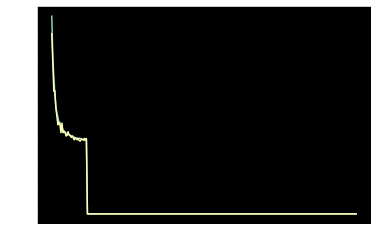


Training Finished. 
Training Time (in minutes) = 0.8729891061782837


In [18]:
public_model.load_state_dict(torch.load('./resources/public_model_84.pt'))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(public_model.parameters(), lr=0.00001)

public_model.train()

time0 = time()
epochs = 300
last_loss = 100
patience = 4
trigger_times = 0
loss_margin = 0.01

losses = np.zeros((epochs,2))

for epoch in range(epochs):  # loop over the dataset multiple times

    with torch.enable_grad():
        public_model.train()
        running_loss = 0.0
        for data in public_trainloader:
            # get data
            images = data['image']
            labels = data['label']

            # send to device
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = public_model(images)
            loss = loss_fn(outputs[0], labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(public_trainloader)))
            losses[epoch,0] = running_loss/len(public_trainloader)

    with torch.no_grad():
        public_model.eval()
        loss_total = 0
        for data in public_valloader:
            outputs = public_model(data['image'].to(device))
            loss = loss_fn(outputs[0],data['label'].to(device))
            loss_total += loss.item()
    
    current_loss = loss_total / len(public_valloader)
    print('current val loss: ', current_loss)
    losses[epoch,1] = current_loss

    print(current_loss - (running_loss/len(trainloader)))

    if (current_loss - (running_loss/len(trainloader))) > loss_margin:
        trigger_times += 1
        if trigger_times > patience:
            print('Early stopping!')
            path = f"./test_gen_data/public_ft_model_{epoch}.pt"
            torch.save(public_model.state_dict(), path)
            if trigger_times > patience and trigger_times < (patience + 2):
                path_to_use = path
                break
    last_loss = current_loss


plt.ion()
fig, ax = plt.subplots()
x = range(epochs)
plot0, = ax.plot(x, losses[:,0])
plot1, = ax.plot(x, losses[:,1])
plt.show()
print("\nTraining Finished. \nTraining Time (in minutes) =",(time()-time0)/60)

**Testing**

In [19]:
public_model.load_state_dict(torch.load(path_to_use))

y_pred_2 = []
y_true_2 = []

with torch.no_grad():
    public_model.eval()
    correct, total = 0, 0
    for data in public_testloader:
        outputs = public_model(data['image'].to(device))
        _, prediction = torch.max(outputs[0], 1)
        y_pred_2.extend(prediction.cpu()) # Save Prediction
        y_true_2.extend(data['label']) # Save Truth
        for i in range(len(data['label'])):
            if(prediction[i]==data['label'][i]):
                correct += 1
            total += 1

print("Number Of Images Tested =", total)
print("\nModel Accuracy =", (correct/total))

Number Of Images Tested = 2059

Model Accuracy = 0.48712967459932005


<AxesSubplot:>

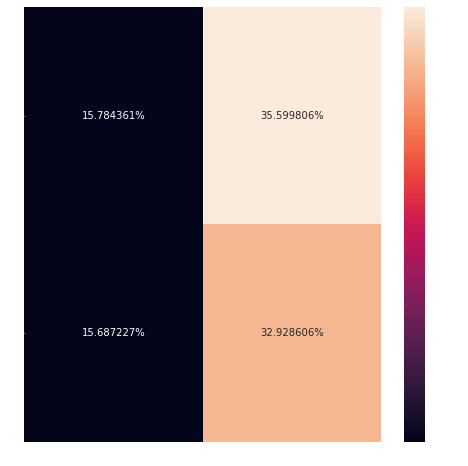

In [20]:
# labels for classes
classes = ('Digit', 'Letter')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true_2, y_pred_2)
# print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True, fmt='%')